## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Описание данных
* 		children — количество детей в семье
* 		days_employed — общий трудовой стаж в днях
* 		dob_years — возраст клиента в годах
* 		education — уровень образования клиента
* 		education_id — идентификатор уровня образования
* 		family_status — семейное положение
* 		family_status_id — идентификатор семейного положения
* 		gender — пол клиента
* 		income_type — тип занятости
* 		debt — имел ли задолженность по возврату кредитов
* 		total_income — ежемесячный доход
* 		purpose — цель получения кредита

В конце исследования ответим на следующие вопросы:

* Есть ли зависимость между наличием детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?

## Оглавление

1. [Первый взгляд на данные](#start)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропущенных значений](#null)
    * [Замена типов данных](#typeconversion)
    * [Обработка дубликатов](#duplicates)
    * [Лемматизация](#lemmatization)
    * [Категоризация данных](#categorizing)
3. [Ответы на вопросы исследования](#questions)
4. [Общий вывод](#final_conclusion)

### Шаг 1. Первый взгляд на данные. <a id="start"></a>

In [ ]:
import pandas as pd
df = pd.read_csv('/datasets/data.csv')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


### Вывод

Имена столбцов корректные: строчные, латиницей. Есть одинаковое количество пропущенных значений в столбцах days_employed и total_income. Есть отрицательные значения в таблице days_employed и сам тип значений столбца вещественный, хотя должен быть целочисленным. В столбце education значения прописаны не единообразно: "Среднее", "СРЕДНЕЕ", "среднее", - потребуется привести к нижнему регистру. В столбце purpose слишком много повторяющихся значений: "сыграть свадьбу", "на проведение свадьбы", - потребуется лемматизация и категоризация. Найдено 54 полных дубликата. В первую очередь нужно исправить недочеты в данных.

### Шаг 2. Предобработка данных <a id="preprocessing"></a>

### Обработка пропусков <a id="null"></a>

In [ ]:
df['days_employed'] = df['days_employed'].abs()
days_employed_median = df['days_employed'].median()
df['days_employed'] = df['days_employed'].fillna(days_employed_median)
print(df.groupby('income_type')['total_income'].median())
df['total_income'] = df['total_income'].fillna(df.groupby('income_type')['total_income'].transform('median'))

income_type
безработный        131339.751676
в декрете           53829.130729
госслужащий        150447.935283
компаньон          172357.950966
пенсионер          118514.486412
предприниматель    499163.144947
сотрудник          142594.396847
студент             98201.625314
Name: total_income, dtype: float64


### Вывод

Обнаружены одинаковые пропуски в столбцах days_employed и total_income. В days_employed необъяснимо много отрицательных значений, природу этих артефактов исследовать не стал, так как эти данные не нужны для исследования: просто отрицательные значения перевел в положительные (например, -11 в 11) и заполнил пропуски медианой методом fillna. Пропуски в total_income и days_employed появились, скорее всего, потому, что не известно место работы, либо его просто нет. Пропуски в total_income заполнил медианой в зависимости от типа доходов: если нет дохода в строке с типом дохода 'сотрудник', то заполнил его медианным значениям по доходу предпринимателей, наемных сотрудников и т. п.

### Замена типа данных <a id="typeconversion"></a>

In [ ]:
df['days_employed'] = df['days_employed'].astype('int64')
df['total_income'] = df['total_income'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


### Вывод

Поменял тип данных в столбцах days_employed и total_income на целочисленный методом astype. Дни не могут быть дробными.

### Обработка дубликатов <a id="duplicates"></a>

In [ ]:
print(df.duplicated().sum())
df = df.drop_duplicates()
df.info()

54
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21471 entries, 0 to 21524
Data columns (total 12 columns):
children            21471 non-null int64
days_employed       21471 non-null int64
dob_years           21471 non-null int64
education           21471 non-null object
education_id        21471 non-null int64
family_status       21471 non-null object
family_status_id    21471 non-null int64
gender              21471 non-null object
income_type         21471 non-null object
debt                21471 non-null int64
total_income        21471 non-null int64
purpose             21471 non-null object
dtypes: int64(7), object(5)
memory usage: 2.1+ MB


Избавился от полных дубликатов. Для их поиска и удаления воспользовался методом drop_duplicates(). Было найдено 54 дубликата - так как в данных нет уникального id заемщика, то, возможно, это просто разные люди, но знать точно не можем, поэтому удалил.

In [ ]:
print(df['children'].value_counts())
df[df['children'] == -1].head(10)

 0     14107
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,4417,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816,профильное образование
705,-1,902,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882,приобретение автомобиля
742,-1,3174,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268,дополнительное образование
800,-1,349987,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293,дополнительное образование
941,-1,2194,57,Среднее,1,женат / замужем,0,F,пенсионер,0,118514,на покупку своего автомобиля
1363,-1,1195,55,СРЕДНЕЕ,1,женат / замужем,0,F,компаньон,0,69550,профильное образование
1929,-1,1461,38,среднее,1,Не женат / не замужем,4,M,сотрудник,0,109121,покупка жилья
2073,-1,2539,42,среднее,1,в разводе,3,F,компаньон,0,162638,покупка жилья
3814,-1,3045,26,Среднее,1,гражданский брак,1,F,госслужащий,0,131892,на проведение свадьбы
4201,-1,901,41,среднее,1,женат / замужем,0,F,госслужащий,0,226375,операции со своей недвижимостью


У 47 человек в столбце дети стоит "-1". Так как для исследования нам  нужен столбец о количестве детей, а сделать обоснованное предположение о реальном количестве мы не можем, просто удалим строки с этим значением.

In [ ]:
df.drop(df[df['children'] == -1].index, inplace=True)
df['children'].value_counts()

0     14107
1      4809
2      2052
3       330
20       76
4        41
5         9
Name: children, dtype: int64

Есть артефакт с 20-ю детьми, решил его оставить, так как нам важно только наличие детей. Дальше посмотрим разброс значений в других столбцах, чтобы понять, с какими из них требуется работа.

In [ ]:
df['family_status'].value_counts()

женат / замужем          12310
гражданский брак          4146
Не женат / не замужем     2805
в разводе                 1191
вдовец / вдова             955
Name: family_status, dtype: int64

In [ ]:
df['family_status_id'].value_counts()

0    12310
1     4146
4     2805
3     1191
2      955
Name: family_status_id, dtype: int64

In [ ]:
df['gender'].value_counts()

F      14139
M       7267
XNA        1
Name: gender, dtype: int64

In [ ]:
df['debt'].value_counts()

0    19667
1     1740
Name: debt, dtype: int64

In [ ]:
df['income_type'].value_counts()

сотрудник          11058
компаньон           5069
пенсионер           3821
госслужащий         1453
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

Количество ячеек, где возраст указан меньше 18: 101


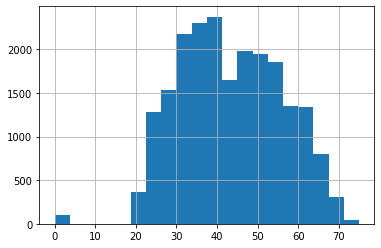

In [ ]:
df['dob_years'].hist(bins=20)
print('Количество ячеек, где возраст указан меньше 18:', df[df['dob_years'] < 18]['children'].count())

In [ ]:
df[df['dob_years'] < 18].head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_level,purpose_category,has_children
99,0,346541,0,среднее,1,женат / замужем,0,F,пенсионер,0,71291,автомобиль,низкий,автомобиль,False
149,0,2664,0,среднее,1,в разводе,3,F,сотрудник,0,70176,операции с жильем,низкий,недвижимость,False
270,3,1872,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166,ремонт жилью,низкий,недвижимость,True
578,0,397856,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620,строительство собственной недвижимости,низкий,недвижимость,False
1040,0,1158,0,высшее,0,в разводе,3,F,компаньон,0,303994,свой автомобиль,высокий,автомобиль,False


В столбце gender есть одна строка со значением 'XNA' - оставим ее, так как пол не нужен для нашего исследования. В столбце dob_years у 101 возраст указан меньше 18, есть даже новорожденные пенсионеры :). Так как возраст не используем в исследовании, то оставим эти ячейки нетронутыми. В столбцах 'family_status', 'family_status_id', 'income type' и 'debt' аномалий не обнаружено.

In [ ]:
df['education'] = df['education'].str.lower()
print(df['education'].value_counts())

среднее                15151
высшее                  5242
неоконченное высшее      743
начальное                282
ученая степень             6
Name: education, dtype: int64


В столбце 'education' убрал дубликаты с разным регистром: "Среднее" и "среднее" теперь одно и то же. Посмотрю, появились ли дубликаты. Если да, уберу их.

In [ ]:
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

17
0


### Вывод

С помощь метода drop_duplicates избавился от полных дубликатов. Убрал разнобой в регистрах в столбце 'education'. Удалил строки, где количество детей указано как -1: нельзя изменять, потому что нет оснований приписывать определенное количество детей, но и нельзя оставлять, так как этот параметр нам нужен для исследования. Есть небольшие аномалии в столбцах 'gender' и 'dob_years', решил их не трогать, так как данных этих столбцов для исследования не нужны.

### Лемматизация <a id="lemmatization"></a>

In [ ]:
from pymystem3 import Mystem
m = Mystem() 
purpose_lemmas = m.lemmatize(df['purpose'].str.cat(sep=' '))
from collections import Counter
print(Counter(purpose_lemmas))

Counter({' ': 54908, 'недвижимость': 6335, 'покупка': 5884, 'жилье': 4452, 'автомобиль': 4295, 'образование': 4003, 'с': 2913, 'операция': 2597, 'свадьба': 2322, 'свой': 2223, 'на': 2218, 'строительство': 1874, 'высокий': 1373, 'получение': 1312, 'коммерческий': 1310, 'для': 1288, 'жилой': 1225, 'сделка': 940, 'заниматься': 904, 'дополнительный': 903, 'подержать': 851, 'проведение': 767, 'сыграть': 764, 'сдача': 650, 'семья': 638, 'собственный': 634, 'со': 624, 'ремонт': 606, 'приобретение': 459, 'профильный': 434, 'подержанный': 111, '\n': 1})


С помощью метода str.cat добавил все слова в один большой текст, а потом их лемматизировал и посчитал, как часто те или иные леммы встречаются в столбце: примерно понял, по каким леммам можно категоризировать цель кредита. Берем самые популярные леммы и удаляем непоказательные типа "покупка" или "операция".

### Вывод

Лемматизация показала, что кредит берут для операций с недвижимостью, покупки автомобиля, свадьбы и образования. Это позволит на следующем шаге категоризировать цели кредита.

### Категоризация данных <a id="categorizing"></a>

In [ ]:
df['total_income'].describe()
def income_level(row):
    if row['total_income'] <= df['total_income'].quantile(q=0.25):
        return 'низкий'
    elif row['total_income'] <= df['total_income'].quantile(q=0.5):
        return 'ниже среднего'
    elif row['total_income'] <= df['total_income'].quantile(q=0.75):
        return 'выше среднего'
    else:
        return 'высокий'

df['income_level'] = df.apply(income_level, axis=1)

In [ ]:
df['income_level'].value_counts()

ниже среднего    5468
высокий          5352
низкий           5352
выше среднего    5235
Name: income_level, dtype: int64

In [ ]:
def purpose_category(row):
    if ('недвижимость' in m.lemmatize(row['purpose'])) or ('жилье' in m.lemmatize(row['purpose'])):
        return 'недвижимость'
    if 'свадьба' in m.lemmatize(row['purpose']):
        return 'свадьба'
    if 'автомобиль' in m.lemmatize(row['purpose']):
        return 'автомобиль'
    if 'образование' in m.lemmatize(row['purpose']):
        return 'образование'
    
    

df['purpose_category'] = df.apply(purpose_category, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21407 entries, 0 to 21524
Data columns (total 14 columns):
children            21407 non-null int64
days_employed       21407 non-null int64
dob_years           21407 non-null int64
education           21407 non-null object
education_id        21407 non-null int64
family_status       21407 non-null object
family_status_id    21407 non-null int64
gender              21407 non-null object
income_type         21407 non-null object
debt                21407 non-null int64
total_income        21407 non-null int64
purpose             21407 non-null object
income_level        21407 non-null object
purpose_category    21407 non-null object
dtypes: int64(7), object(7)
memory usage: 2.4+ MB


In [ ]:
print(df['purpose_category'].value_counts())

недвижимость    10787
автомобиль       4295
образование      4003
свадьба          2322
Name: purpose_category, dtype: int64


### Вывод

По уровню доходов категоризовал по 4 квартилям: низкий доход (1-й квартиль), ниже среднего, выше среднего, высокий. По целям кредита выделил следующие категории: "недвижимость", "автомобиль", "образование", "свадьба": не стал их разбивать дальше, например, до "ремонта недвижимости" или "дополнительного образования", потому что есть ячейки просто "операции с недвижимостью", которые не ясно, куда отнести. Метод info() показал, что мы присвоили категорию каждому заемщику.

### Шаг 3. Ответы на вопросы исследования <a id="questions"></a>

#### Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [ ]:
df['has_children'] = df['children'] > 0
df.pivot_table(index=['has_children'], values=["debt"], aggfunc=['count','sum','mean'])

,count,sum,mean
,debt,debt,debt
has_children,,,
False,14091,1063,0.075438
True,7316,677,0.092537


Заемщики с детьми отдают кредиты хуже, чем заемщики без детей. Наверное, потому, что людям приходится дополнительно тратиться на детей.

#### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [ ]:
df.groupby('family_status').agg(total_people=('debt', 'count'), loan_overdue_total=('debt','sum'),
   loan_overdue_ratio=('debt', 'mean'))


,total_people,loan_overdue_total,loan_overdue_ratio
family_status,,,
Не женат / не замужем,2805,274,0.097683
в разводе,1191,85,0.071369
вдовец / вдова,955,63,0.065969
гражданский брак,4146,388,0.093584
женат / замужем,12310,930,0.075548


Скорее всего, семейное положение коррелирует с процентом просрочек, но не является их причиной. Причина, видимо, в возрасте. Больше похоже на то, что чем старше заемщик, тем реже допускает просрочки по кредиту, потому что самые молодые обычно находятся в гражданском браке (9.29% просрочек), потом заключают официальный (7.52%), потом разводятся (7.11%) и самые пожилые - вдовцы (6.56%).

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [ ]:
df.groupby('income_level').agg(total_people=('debt', 'count'), loan_overdue_total=('debt','sum'), loan_overdue_ratio=('debt', 'mean'))

,total_people,loan_overdue_total,loan_overdue_ratio
income_level,,,
высокий,5352,383,0.071562
выше среднего,5235,447,0.085387
ниже среднего,5468,483,0.088332
низкий,5352,427,0.079783


Меньше всего просрочек допускают люди с самыми высокими доходами и самыми низкими доходами. Предположу, у первых есть деньги, чтобы расплатиться, а вторым не выдают крупные кредиты.

#### Как разные цели кредита влияют на его возврат в срок?

In [ ]:
df.groupby('purpose_category').agg(total_people=('debt', 'count'), loan_overdue_total=('debt','sum'), loan_overdue_ratio=('debt', 'mean'))

,total_people,loan_overdue_total,loan_overdue_ratio
purpose_category,,,
автомобиль,4295,402,0.093597
недвижимость,10787,782,0.072495
образование,4003,370,0.092431
свадьба,2322,186,0.080103


Чаще всего допускают просрочку люди, которые берут кредит на автомобиль и образование. Видимо, кредит на образование берут в несознательном возрасте. А автомобиль повышает, а не снижает нагрузку на семейный бюджет. Реже всего допускают переплаты заемщики, которые берут кредит для операций с недвижимостью.

### Шаг 4. Общий вывод <a id="final_conclusion"></a>

Данные качественные, заполнил пропуски в столбцах с доходом, которого нет у примерно 10% заемщиков, медианой по каждому типа дохода. Удалил строки, где было указано "-1" детей, так как надо было ответить на вопрос про связь наличия детей и вероятности просрочки по кредиту. Категоризовал данные по цели кредита: недвижимость, автомобиль, свадьба, образование.

* В среднем 8% заемщиков допускают просрочки по кредиту. 
* Плохо отдают кредиты, кто берут их на образование и автомобиль: просрочка допускает 9.36% и 9.24% заемщиков соответственно. Заемщики, которые берут кредит на операции с недвижимостью, одни из самых надежных: только 7.24% допускают просрочки.
* Есть зависимость между семейным положением и сроком возврата кредита, но, скорее всего, она обусловлена возрастом: вдовцы допускают просрочку в полтора раза реже, чем люди в гражданском браке: 6.56% против 9.29%. 
* Заемщики без детей надежнее заемщиков с детьми: 7.51% просрочек против 9.24%. 
* Еще реже допускают просрочки заемщики с самыми высокими доходами: только 7.17%.